<a href="https://colab.research.google.com/github/Nageswar-Sahoo/S5/blob/main/EVA7_Assignment_S5_File_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


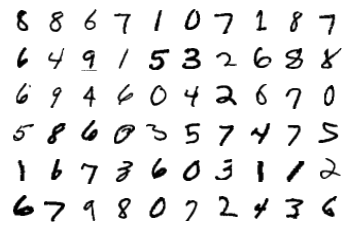

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          18,432
              ReLU-6           [-1, 64, 22, 22]               0
         MaxPool2d-7           [-1, 64, 11, 11]               0
            Conv2d-8           [-1, 16, 11, 11]           1,024
              ReLU-9           [-1, 16, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]           9,216
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
             ReLU-13             [-1, 64, 7, 7]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.31060096621513367 Batch_id=468 Accuracy=39.29: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]



Test set: Average loss: 0.2827, Accuracy: 9140/10000 (91.40%)

EPOCH: 1


Loss=0.10269287973642349 Batch_id=468 Accuracy=93.81: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]



Test set: Average loss: 0.1131, Accuracy: 9647/10000 (96.47%)

EPOCH: 2


Loss=0.08481055498123169 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]



Test set: Average loss: 0.0864, Accuracy: 9718/10000 (97.18%)

EPOCH: 3


Loss=0.0154317207634449 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]



Test set: Average loss: 0.0606, Accuracy: 9806/10000 (98.06%)

EPOCH: 4


Loss=0.12013938277959824 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s]



Test set: Average loss: 0.0542, Accuracy: 9829/10000 (98.29%)

EPOCH: 5


Loss=0.11052694916725159 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]



Test set: Average loss: 0.0573, Accuracy: 9799/10000 (97.99%)

EPOCH: 6


Loss=0.04738830402493477 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]



Test set: Average loss: 0.0440, Accuracy: 9848/10000 (98.48%)

EPOCH: 7


Loss=0.028591878712177277 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]



Test set: Average loss: 0.0549, Accuracy: 9816/10000 (98.16%)

EPOCH: 8


Loss=0.024230828508734703 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]



Test set: Average loss: 0.0392, Accuracy: 9874/10000 (98.74%)

EPOCH: 9


Loss=0.06238224729895592 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:16<00:00, 28.57it/s]



Test set: Average loss: 0.0431, Accuracy: 9857/10000 (98.57%)

EPOCH: 10


Loss=0.01674261875450611 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]



Test set: Average loss: 0.0584, Accuracy: 9821/10000 (98.21%)

EPOCH: 11


Loss=0.006639554630964994 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]



Test set: Average loss: 0.0397, Accuracy: 9870/10000 (98.70%)

EPOCH: 12


Loss=0.035473812371492386 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.33it/s]



Test set: Average loss: 0.0387, Accuracy: 9869/10000 (98.69%)

EPOCH: 13


Loss=0.03921862691640854 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]



Test set: Average loss: 0.0505, Accuracy: 9844/10000 (98.44%)

EPOCH: 14


Loss=0.03227601572871208 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]



Test set: Average loss: 0.0390, Accuracy: 9872/10000 (98.72%)



Text(0.5, 1.0, 'Test Accuracy')

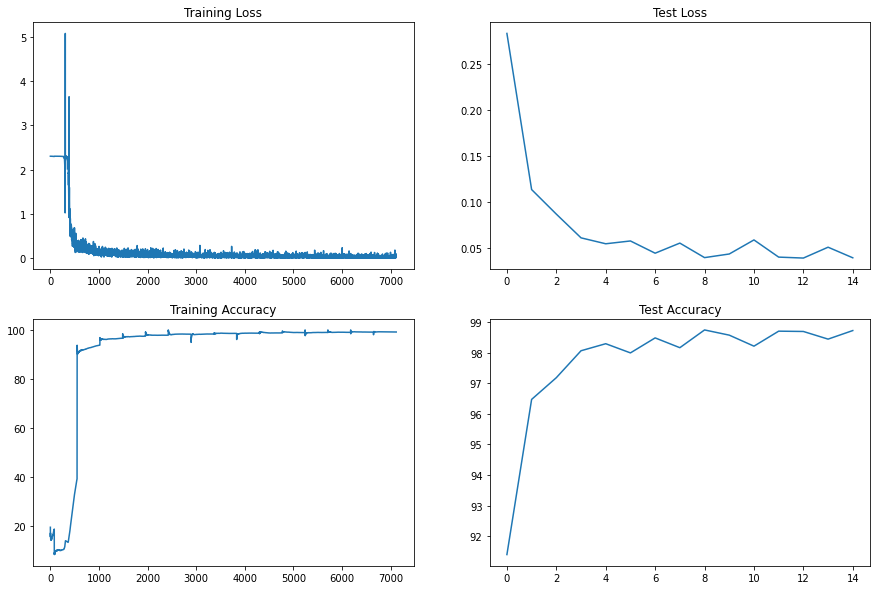

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:

1 - Get the basic setup

2 - Set Transforms

3 - Set Data Loader

4 - Set Basic Working Code

5 - Set Basic Training  & Test Loop

6 - Results:

    1 - Parameters: 75,828
    2 - Best Training Accuracy: 99.16
    3 - Best Test Accuracy: 98.72
1 - Analysis:

    1 - Model Parameters is more and it's a heavy model . 
    2 - Model is over-fitting , we will make our model lighter in next step 


